### 라이브러리 정의

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import requests
import time
import io
from scipy.interpolate import RBFInterpolator
from math import radians, sin, cos, sqrt, atan2
from sklearn.gaussian_process.kernels import RBF
import folium
from folium.plugins import HeatMap

import pandas as pd
import numpy as np

from shapely.geometry import Polygon
from shapely.geometry import Point
from folium.plugins import MarkerCluster
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config
import joblib  # 모델 저장용
import webbrowser
from model_class import Models


### 한글처리
plt.rc("font", family="Malgun Gothic")

# - 마이너스 기호 깨짐 처리
plt.rcParams["axes.unicode_minus"] = False



### 날씨 데이터 불러들이기

In [ ]:
# 캘리포니아 경계 좌표
lat_range = (32.5, 42.0)
lon_range = (-124.5, -114.0)

# 0.1도 간격 격자 생성 (약 10km)
lat_points = np.arange(lat_range[0], lat_range[1], 0.1)
lon_points = np.arange(lon_range[0], lon_range[1], 0.1)
grid = [(lat, lon) for lat in lat_points for lon in lon_points]
grid_df = pd.DataFrame(grid, columns=["latitude", "longitude"])

# K-Means 클러스터링: 캘리포니아 좌표를 50개의 대표 좌표로 압축
# 목적: API 요청 횟수를 줄이고 데이터 크기를 줄이면서 지역적 대표성을 유지
kmeans = KMeans(n_clusters=50, random_state=42)
grid_df["cluster"] = kmeans.fit_predict(grid_df[["latitude", "longitude"]])
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=["latitude", "longitude"])

# 클러스터링 결과 확인
print("클러스터 중심 좌표 (50개 대표 좌표):")
print(cluster_centers.head())

# 클러스터 중심에서 기상 데이터 수집
start_date = "20150101"
end_date = "20250228"

def get_skiprows(response_text):
    lines = response_text.splitlines()
    skiprows = 0
    for line in lines:
        if line.strip() == "YEAR,DOY,T2M,WS2M,RH2M,PRECTOTCORR":
            break
        skiprows += 1
    return skiprows

def get_weather_data(latitude, longitude):
    url = f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=T2M,WS2M,RH2M,PRECTOTCORR&community=AG&longitude={longitude}&latitude={latitude}&start={start_date}&end={end_date}&format=CSV"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        if response.status_code == 200:
            # 응답 데이터 구조 확인 (디버깅용)
            print(f"응답 데이터 상단 15줄 (위도: {latitude}, 경도: {longitude}):")
            print("\n".join(response.text.splitlines()[:15]))
            # 동적으로 skiprows 계산
            skiprows = get_skiprows(response.text)
            return pd.read_csv(io.StringIO(response.text), skiprows=skiprows, header=0)
        else:
            print(f"데이터 요청 실패! 상태 코드: {response.status_code}, 위도: {latitude}, 경도: {longitude}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"요청 오류 발생: {e}, 위도: {latitude}, 경도: {longitude}")
        return None

weather_data_list = []
for idx, row in cluster_centers.iterrows():
    print(f"요청 중: 클러스터 {idx} (위도 {row['latitude']}, 경도 {row['longitude']})")
    weather_data = get_weather_data(row["latitude"], row["longitude"])
    if weather_data is not None:
        weather_data["latitude"] = row["latitude"]
        weather_data["longitude"] = row["longitude"]
        weather_data_list.append(weather_data)
    time.sleep(5)  # API 요청 간 대기

# 데이터프레임 병합
weather_df = pd.concat(weather_data_list, ignore_index=True)

# acq_date 생성
weather_df["acq_date"] = pd.to_datetime(weather_df["YEAR"].astype(str) + weather_df["DOY"].astype(str), format="%Y%j")

# 결과 출력
print("\n기상 데이터 정보:")
print(weather_df.info())
print(weather_df.head(5))

# 저장
weather_df.to_csv("./USA data/clustered_weather_data.csv", index=False)

### 데이터 병합

In [ ]:
# Haversine 공식으로 거리 계산
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # 지구 반지름 (km)
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# IDW(역거리 가중 보간) 함수
def idw_interpolation(row, weather_df, weather_vars):
    # 동일 날짜의 기상 데이터만 필터링
    weather_subset = weather_df[weather_df["acq_date"] == row["acq_date"]]
    
    # 기상 데이터가 존재하지 않으면 None 반환
    if weather_subset.empty:
        return pd.Series([None] * len(weather_vars), index=weather_vars)
    
    # 기상 데이터에서 산불 데이터의 위치와 거리를 계산
    distances = weather_subset.apply(
        lambda w: haversine(row["latitude"], row["longitude"], w["latitude"], w["longitude"]), axis=1
    )
    
    # 거리가 0인 경우를 방지하기 위해 최소값 설정
    distances = distances.replace(0, 1e-10)  # 0을 작은 값으로 대체
    weights = 1 / (distances ** 2)
    
    # 가중합 계산
    weighted_sum = (weather_subset[weather_vars].multiply(weights, axis=0)).sum()
    
    # 가중합을 가중치 합으로 나누어 보간된 값 계산
    return weighted_sum / weights.sum()

# 1. 산불 데이터 로드
wildfire_dfs = {
    'aS1': pd.read_csv("./USA data/fire_archive_SV-C2_590694.csv"),
    'nS1': pd.read_csv("./USA data/fire_nrt_SV-C2_590694.csv"),
}

# 2. 날씨 데이터 로드
weather_df = pd.read_csv("./USA data/clustered_weather_data.csv")

# 3. 성능 최적화: dtypes 최적화
# 메모리 사용량을 줄이기 위해 float32 사용
for df in wildfire_dfs.values():
    df["latitude"] = df["latitude"].astype("float32")
    df["longitude"] = df["longitude"].astype("float32")

weather_df["latitude"] = weather_df["latitude"].astype("float32")
weather_df["longitude"] = weather_df["longitude"].astype("float32")
weather_df["T2M"] = weather_df["T2M"].astype("float32")
weather_df["WS2M"] = weather_df["WS2M"].astype("float32")
weather_df["RH2M"] = weather_df["RH2M"].astype("float32")
weather_df["PRECTOTCORR"] = weather_df["PRECTOTCORR"].astype("float32")

# 4. 산불 데이터 처리
for df in wildfire_dfs.values():
    df["acq_date"] = pd.to_datetime(df["acq_date"])

wildfire_df = pd.concat(wildfire_dfs.values(), ignore_index=True)

# 5. 기상 데이터 처리
weather_df["acq_date"] = pd.to_datetime(weather_df["YEAR"].astype(str) + weather_df["DOY"].astype(str), format="%Y%j")

# 성능 최적화: 병합 전 필터링 (2025-03-01 이전 데이터만 사용)
cutoff_date = pd.Timestamp("2025-03-01")
weather_df = weather_df[weather_df["acq_date"] <= cutoff_date]
wildfire_df = wildfire_df[wildfire_df["acq_date"] <= cutoff_date]

# 6. 기상 데이터 보간 (클러스터별로 RBF 보간)
# 클러스터 식별을 위해 latitude와 longitude 조합으로 고유 키 생성
weather_df["cluster_id"] = weather_df["latitude"].astype(str) + "_" + weather_df["longitude"].astype(str)

# 보간 전 결측치 확인
print("보간 전 결측치:")
print(weather_df[["T2M", "WS2M", "RH2M", "PRECTOTCORR"]].isnull().sum())

# RBF 보간 적용
weather_vars = ["T2M", "WS2M", "RH2M", "PRECTOTCORR"]
for cluster_id in weather_df["cluster_id"].unique():
    cluster_data = weather_df[weather_df["cluster_id"] == cluster_id].copy()
    if cluster_data[weather_vars].isnull().any().any():
        # 시간 축 (acq_date를 숫자로 변환)
        time_points = (cluster_data["acq_date"] - cluster_data["acq_date"].min()).dt.days.values
        # 결측치가 없는 데이터만 사용
        for var in weather_vars:
            mask = ~cluster_data[var].isnull()
            if mask.sum() > 1:  # 최소 2개 이상의 데이터 포인트 필요
                rbf = RBFInterpolator(
                    time_points[mask].reshape(-1, 1),
                    cluster_data[var][mask],
                    kernel="thin_plate_spline"
                )
                # 결측치가 있는 위치에 대해 보간
                missing_mask = cluster_data[var].isnull()
                if missing_mask.any():
                    interpolated_values = rbf(time_points[missing_mask].reshape(-1, 1))
                    cluster_data.loc[missing_mask, var] = interpolated_values
        # 보간된 데이터로 업데이트
        weather_df.loc[weather_df["cluster_id"] == cluster_id, weather_vars] = cluster_data[weather_vars]

# 보간 후 결측치 확인
print("\nRBF 보간 후 결측치:")
print(weather_df[["T2M", "WS2M", "RH2M", "PRECTOTCORR"]].isnull().sum())

# 7. IDW 보간으로 기상 데이터 매핑
wildfire_df[weather_vars] = wildfire_df.apply(
    lambda row: idw_interpolation(row, weather_df, weather_vars), axis=1
)

# 병합된 데이터프레임 생성
merged_df = wildfire_df.copy()

# 병합 후 결측치 확인 (기상 데이터 매핑 검증)
print("\nIDW 적용 후 결측치:")
print(merged_df[weather_vars].isnull().sum())

# 8. 결측치 처리: 결측치가 있는 행은 선형 보간으로 채우기
for var in weather_vars:
    merged_df[var] = merged_df[var].interpolate(method='linear')

# 결측치 처리 후 확인
print("\n결측치 처리 후 결측치:")
print(merged_df[weather_vars].isnull().sum())

# 9. 2025년 3월 1일 이후 데이터 삭제 (필터링은 이미 적용됨, datetime 생성만 진행)
if "acq_time" in merged_df.columns:
    merged_df["datetime"] = pd.to_datetime(
        merged_df["acq_date"].astype(str) + " " + merged_df["acq_time"].astype(str).str.zfill(4),
        format="%Y-%m-%d %H%M"
    )
else:
    merged_df["datetime"] = merged_df["acq_date"]

# 10. 필요 없는 컬럼 삭제
columns_to_drop = ["acq_date", "acq_time"]
merged_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# 11. 결과 출력
print("\n병합된 데이터 정보:")
print(merged_df.info())
print(merged_df.head(5))

보간 전 결측치:
T2M            0
WS2M           0
RH2M           0
PRECTOTCORR    0
dtype: int64

RBF 보간 후 결측치:
T2M            0
WS2M           0
RH2M           0
PRECTOTCORR    0
dtype: int64

IDW 적용 후 결측치:
T2M            0
WS2M           0
RH2M           0
PRECTOTCORR    0
dtype: int64

결측치 처리 후 결측치:
T2M            0
WS2M           0
RH2M           0
PRECTOTCORR    0
dtype: int64

병합된 데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906078 entries, 0 to 906077
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   latitude     906078 non-null  float32       
 1   longitude    906078 non-null  float32       
 2   brightness   906078 non-null  float64       
 3   scan         906078 non-null  float64       
 4   track        906078 non-null  float64       
 5   satellite    906078 non-null  object        
 6   instrument   906078 non-null  object        
 7   confidence   906078 non-null  object      

### 산불 면적 계산

In [34]:
# 12. 산불 면적 계산 추가
print("\n산불 면적 계산 시작...")

# 산불 면적 계산 함수
def calculate_fire_area(df):
    # 위도를 라디안으로 변환
    df['latitude_rad'] = np.radians(df['latitude'])
    
    # 기본 면적 계산: scan * track * cos(latitude)
    df['area_base'] = df['scan'] * df['track'] * np.cos(df['latitude_rad'])
    
    # FRP로 보정: area_base * (1 + FRP/100)
    df['predicted_area_km2'] = df['area_base'] * (1 + df['frp'] / 100)
    
    # 불필요한 중간 컬럼 삭제
    df.drop(columns=['latitude_rad', 'area_base'], inplace=True)
    
    return df

# 면적 계산 적용
merged_df = calculate_fire_area(merged_df)
print("산불 면적 계산 완료!")

# 13. 계산 결과 저장
merged_df.to_csv("./USA data/merged_wildfire_weather_check.csv", index=False)
print("계산 결과 저장 완료: merged_wildfire_weather_check.csv")

# 14. 결과 확인
print("\n산불 면적 계산 결과:")
print(merged_df[['latitude', 'longitude', 'frp', 'scan', 'track', 'predicted_area_km2']].head(5))



산불 면적 계산 시작...
산불 면적 계산 완료!
계산 결과 저장 완료: merged_wildfire_weather_check.csv

산불 면적 계산 결과:
    latitude   longitude   frp  scan  track  predicted_area_km2
0  41.187569 -121.769608  1.17  0.44   0.38            0.127300
1  41.187630 -121.765556  1.74  0.44   0.38            0.128017
2  35.519539 -119.727837  1.20  0.39   0.36            0.115645
3  37.823490 -120.961861  0.82  0.39   0.37            0.114918
4  38.910622 -121.170769  1.11  0.40   0.37            0.116441


### 결측치 처리

In [2]:
# 데이터 불러오기
merged_wildfire_df = pd.read_csv("./USA data/merged_wildfire_weather_check.csv", dtype={'version': str})

# 데이터 일부 확인
print("데이터 일부 확인:\n", merged_wildfire_df.head())

# datetime 변환
merged_wildfire_df['datetime'] = pd.to_datetime(merged_wildfire_df['datetime'])

# 결측치 확인
print("결측치 개수 (처리 전):\n", merged_wildfire_df.isnull().sum())

# 결측치 처리 (결측치가 없더라도 명시적으로 처리)
# 현재는 결측치가 없으므로 이 단계는 스킵되지만, 코드에 포함시켜 안정성 확보
merged_wildfire_df = merged_wildfire_df.dropna()

# 결측치 확인 (처리 후)
print("결측치 개수 (처리 후):\n", merged_wildfire_df.isnull().sum())

데이터 일부 확인:
    latitude  longitude  brightness  scan  track satellite instrument  \
0  41.18757 -121.76961      303.88  0.44   0.38         N      VIIRS   
1  41.18763 -121.76556      297.14  0.44   0.38         N      VIIRS   
2  35.51954 -119.72784      302.88  0.39   0.36         N      VIIRS   
3  37.82349 -120.96186      299.62  0.39   0.37         N      VIIRS   
4  38.91062 -121.17077      303.10  0.40   0.37         N      VIIRS   

  confidence version  bright_t31   frp daynight  type       T2M      WS2M  \
0          n       2      266.14  1.17        N   0.0 -3.275956  0.659219   
1          n       2      265.25  1.74        N   0.0 -3.262186  0.663444   
2          n       2      270.62  1.20        N   0.0  4.008612  1.561859   
3          n       2      271.62  0.82        N   0.0  2.606993  1.395697   
4          n       2      272.36  1.11        N   0.0  1.478034  1.415668   

        RH2M  PRECTOTCORR             datetime  predicted_area_km2  
0  68.094241     0.0001

### 이상치 처리

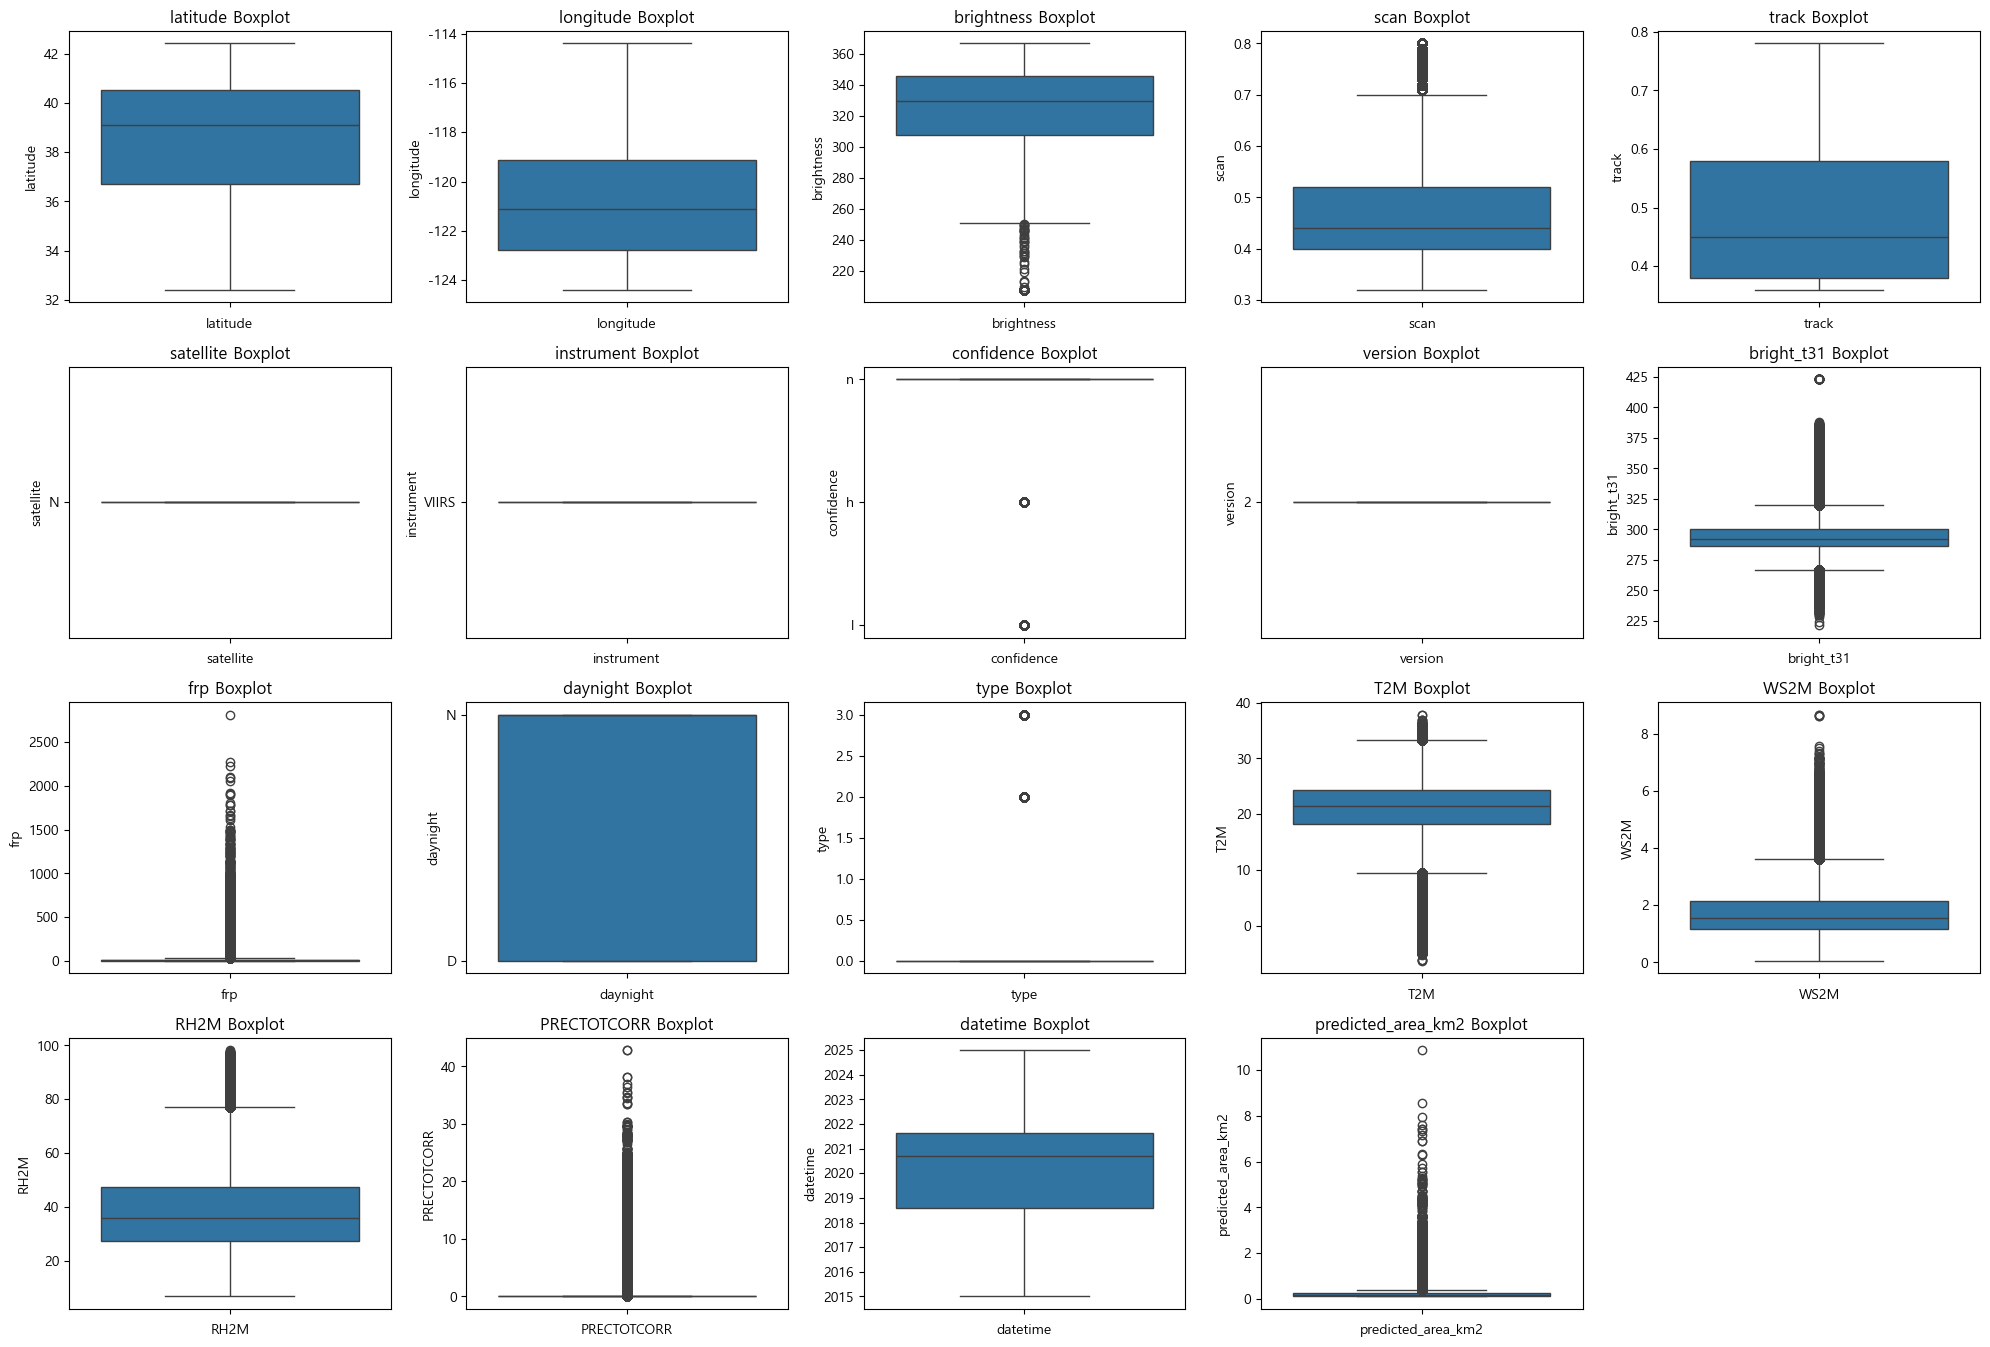

In [37]:
# Boxplot을 통해 이상치 확인 (모든 변수에 대해)
plt.figure(figsize=(20, 20))

# 모든 컬럼에 대해 Boxplot 그리기
for i, v in enumerate(merged_wildfire_df.columns, 1):
    plt.subplot(6, 5, i)  # 6행 5열로 Boxplot을 그려서 모든 변수 확인
    sns.boxplot(merged_wildfire_df[v])
    plt.title(f"{v} Boxplot")
    plt.xlabel(v)

plt.tight_layout()
plt.show()

### 해석
# frp, bright_t31, PRECTOTCORR에서 상당한 수의 이상치(위쪽 점들이 많음)가 존재.
# WS2M(풍속)과 RH2M(습도)도 이상치 존재 → 극단적인 기상 조건에서 산불이 발생했을 가능성이 있음.
# brightness는 상대적으로 이상치가 적고, 비교적 안정적인 분포를 가짐.
# PRECTOTCORR(강수량)에서 극단적으로 높은 값들이 존재 → 이상치 처리가 필요할 수도 있음.

In [3]:
# IQR 계산 및 이상치 처리 함수
def calculate_iqr(df):
    # 수치형 컬럼만 선택
    numeric_columns = df.select_dtypes(include=["number"]).columns
    
    iqr_results = {}
    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        iqr_results[col] = {
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Outliers Count': len(outliers),
            'Outliers': outliers
        }
    
    return iqr_results

# Pandas 데이터프레임에서 바로 처리
iqr_results = calculate_iqr(merged_wildfire_df)

# 결과 출력
for col, result in iqr_results.items():
    print(f"Column: {col}")
    print(f"  Q1: {result['Q1']}")
    print(f"  Q3: {result['Q3']}")
    print(f"  IQR: {result['IQR']}")
    print(f"  Lower Bound: {result['Lower Bound']}")
    print(f"  Upper Bound: {result['Upper Bound']}")
    print(f"  Outliers Count: {result['Outliers Count']}")
    print("")


Column: latitude
  Q1: 36.719677499999996
  Q3: 40.50869
  IQR: 3.7890125000000054
  Lower Bound: 31.036158749999988
  Upper Bound: 46.192208750000006
  Outliers Count: 0

Column: longitude
  Q1: -122.78371
  Q3: -119.14518
  IQR: 3.638530000000003
  Lower Bound: -128.24150500000002
  Upper Bound: -113.68738499999999
  Outliers Count: 0

Column: brightness
  Q1: 307.7
  Q3: 345.7
  IQR: 38.0
  Lower Bound: 250.7
  Upper Bound: 402.7
  Outliers Count: 1205

Column: scan
  Q1: 0.4
  Q3: 0.52
  IQR: 0.12
  Lower Bound: 0.22000000000000003
  Upper Bound: 0.7
  Outliers Count: 23201

Column: track
  Q1: 0.38
  Q3: 0.58
  IQR: 0.19999999999999996
  Lower Bound: 0.08000000000000007
  Upper Bound: 0.8799999999999999
  Outliers Count: 0

Column: bright_t31
  Q1: 286.67
  Q3: 300.0
  IQR: 13.329999999999984
  Lower Bound: 266.67500000000007
  Upper Bound: 319.995
  Outliers Count: 41725

Column: frp
  Q1: 1.83
  Q3: 12.7
  IQR: 10.87
  Lower Bound: -14.475
  Upper Bound: 29.005
  Outliers Count:

In [4]:
# 이상치 처리 함수
def handle_outliers(df):
    """
    데이터프레임의 이상치를 처리하는 함수.
    물리적으로 불가능한 값(예: 음수 풍속, 습도 100% 초과 등)을 클리핑하고,
    유의미한 이상치는 유지하여 데이터의 특성을 보존.
    로그 변환을 통해 비대칭 분포를 정규화하여 모델 학습에 유리한 형태로 변환.
    
    Parameters:
    - df (pd.DataFrame): 이상치 처리를 적용할 데이터프레임
    
    Returns:
    - pd.DataFrame: 이상치가 처리된 데이터프레임
    """
    
    # 위도 (latitude)와 경도 (longitude)는 이상치 처리를 하지 않음
    # 이유: 지리적 데이터로, 캘리포니아 지역 내에서 안정적으로 분포하며 이상치 없음
    
    # brightness (밝기)도 클리핑하지 않음
    # 이유: 밝기가 낮거나 높은 값도 산불 강도와 관련이 있어 유의미할 수 있음
    
    # frp (Fire Radiative Power): 0 이상의 값만 유지
    # 이유: frp는 산불 복사 에너지로, 음수 값은 물리적으로 불가능
    df['frp'] = df['frp'].clip(lower=0)
    
    # frp에 로그 변환 적용
    # 이유: frp의 비대칭 분포(right-skewed)를 정규화하여 모델 학습에 유리
    df['frp'] = np.log1p(df['frp'])

    # scan (스캔): 스캔 값의 범위가 명확하지 않지만, 일반적으로 0과 1 사이일 수 있음
    # 따라서 스캔 값도 처리하지 않음 (클리핑 없음)
    # 이유: 이상치로 표시된 값도 위성 데이터 특성상 유효할 가능성

    # track (트랙): 트랙 값도 명확한 범위가 없으므로 처리하지 않음
    # 이유: 이상치 없음, 안정적인 분포

    # bright_t31 (밝기 t31): 밝기 t31도 클리핑하지 않음
    # 이유: 지표 온도로, 극단적인 값도 산불 상황에서 유의미
    
    # T2M (기온): 기온의 이상치는 없으므로 그대로 두고, 너무 극단적인 값은 없을 것으로 가정
    # 이유: 캘리포니아 지역 기온 범위(-10~40도) 내에서 분포, 이상치도 기후적으로 가능
    
    # WS2M (풍속): 0 이상의 값만 유지
    # 이유: 풍속은 음수일 수 없음
    df['WS2M'] = df['WS2M'].clip(lower=0)

    # RH2M (상대 습도): 0에서 100 사이로 클리핑
    # 이유: 상대습도는 0~100% 범위로 제한해야 함 (100% 이상은 현실적으로 불가능)
    df['RH2M'] = df['RH2M'].clip(lower=0, upper=100)

    # PRECTOTCORR (강수량): 0 이상의 값만 유지
    # 이유: 강수량은 음수일 수 없음
    df['PRECTOTCORR'] = df['PRECTOTCORR'].clip(lower=0)
    
    # PRECTOTCORR에 로그 변환 적용
    # 이유: 강수량의 비대칭 분포(right-skewed)를 정규화하여 이상치 감소 및 모델 학습에 유리
    df['PRECTOTCORR'] = np.log1p(df['PRECTOTCORR'])

    # predicted_area_km2: 0 이상의 값만 유지
    # 이유: 면적은 음수일 수 없으며, IQR 범위에서 음수 값(-0.022 이하) 존재
    df['predicted_area_km2'] = df['predicted_area_km2'].clip(lower=0)
    
    # predicted_area_km2에 로그 변환 적용
    # 이유: 비대칭 분포를 정규화하여 이상치 감소 및 모델 학습에 유리
    df['predicted_area_km2'] = np.log1p(df['predicted_area_km2'])

    return df


# 이상치 처리
cleaned_wildfire_df = handle_outliers(merged_wildfire_df)

# 처리 후 데이터 확인
# 주요 컬럼의 이상치 처리 및 로그 변환 결과 확인
print("이상치 처리 및 로그 변환 후 데이터 확인:")
print(cleaned_wildfire_df[['latitude', 'longitude', 'brightness', 'bright_t31', 'frp', 'scan', 'track', 'T2M', 'WS2M', 'RH2M', 'PRECTOTCORR', 'predicted_area_km2']].head())

# 데이터 타입 확인
# 이상치 처리 및 로그 변환 후 데이터 타입이 변경되지 않았는지 확인
print("\n데이터 타입 확인:")
print(cleaned_wildfire_df.dtypes)

이상치 처리 및 로그 변환 후 데이터 확인:
   latitude  longitude  brightness  bright_t31       frp  scan  track  \
0  41.18757 -121.76961      303.88      266.14  0.774727  0.44   0.38   
1  41.18763 -121.76556      297.14      265.25  1.007958  0.44   0.38   
2  35.51954 -119.72784      302.88      270.62  0.788457  0.39   0.36   
3  37.82349 -120.96186      299.62      271.62  0.598837  0.39   0.37   
4  38.91062 -121.17077      303.10      272.36  0.746688  0.40   0.37   

        T2M      WS2M       RH2M  PRECTOTCORR  predicted_area_km2  
0 -3.275956  0.659219  68.094241     0.000161            0.119825  
1 -3.262186  0.663444  68.034685     0.000164            0.120461  
2  4.008612  1.561859  50.105659     0.007995            0.109433  
3  2.606993  1.395697  56.702233     0.001026            0.108781  
4  1.478034  1.415668  57.134669     0.000682            0.110146  

데이터 타입 확인:
latitude                     float64
longitude                    float64
brightness                   float64
scan 

### EDA

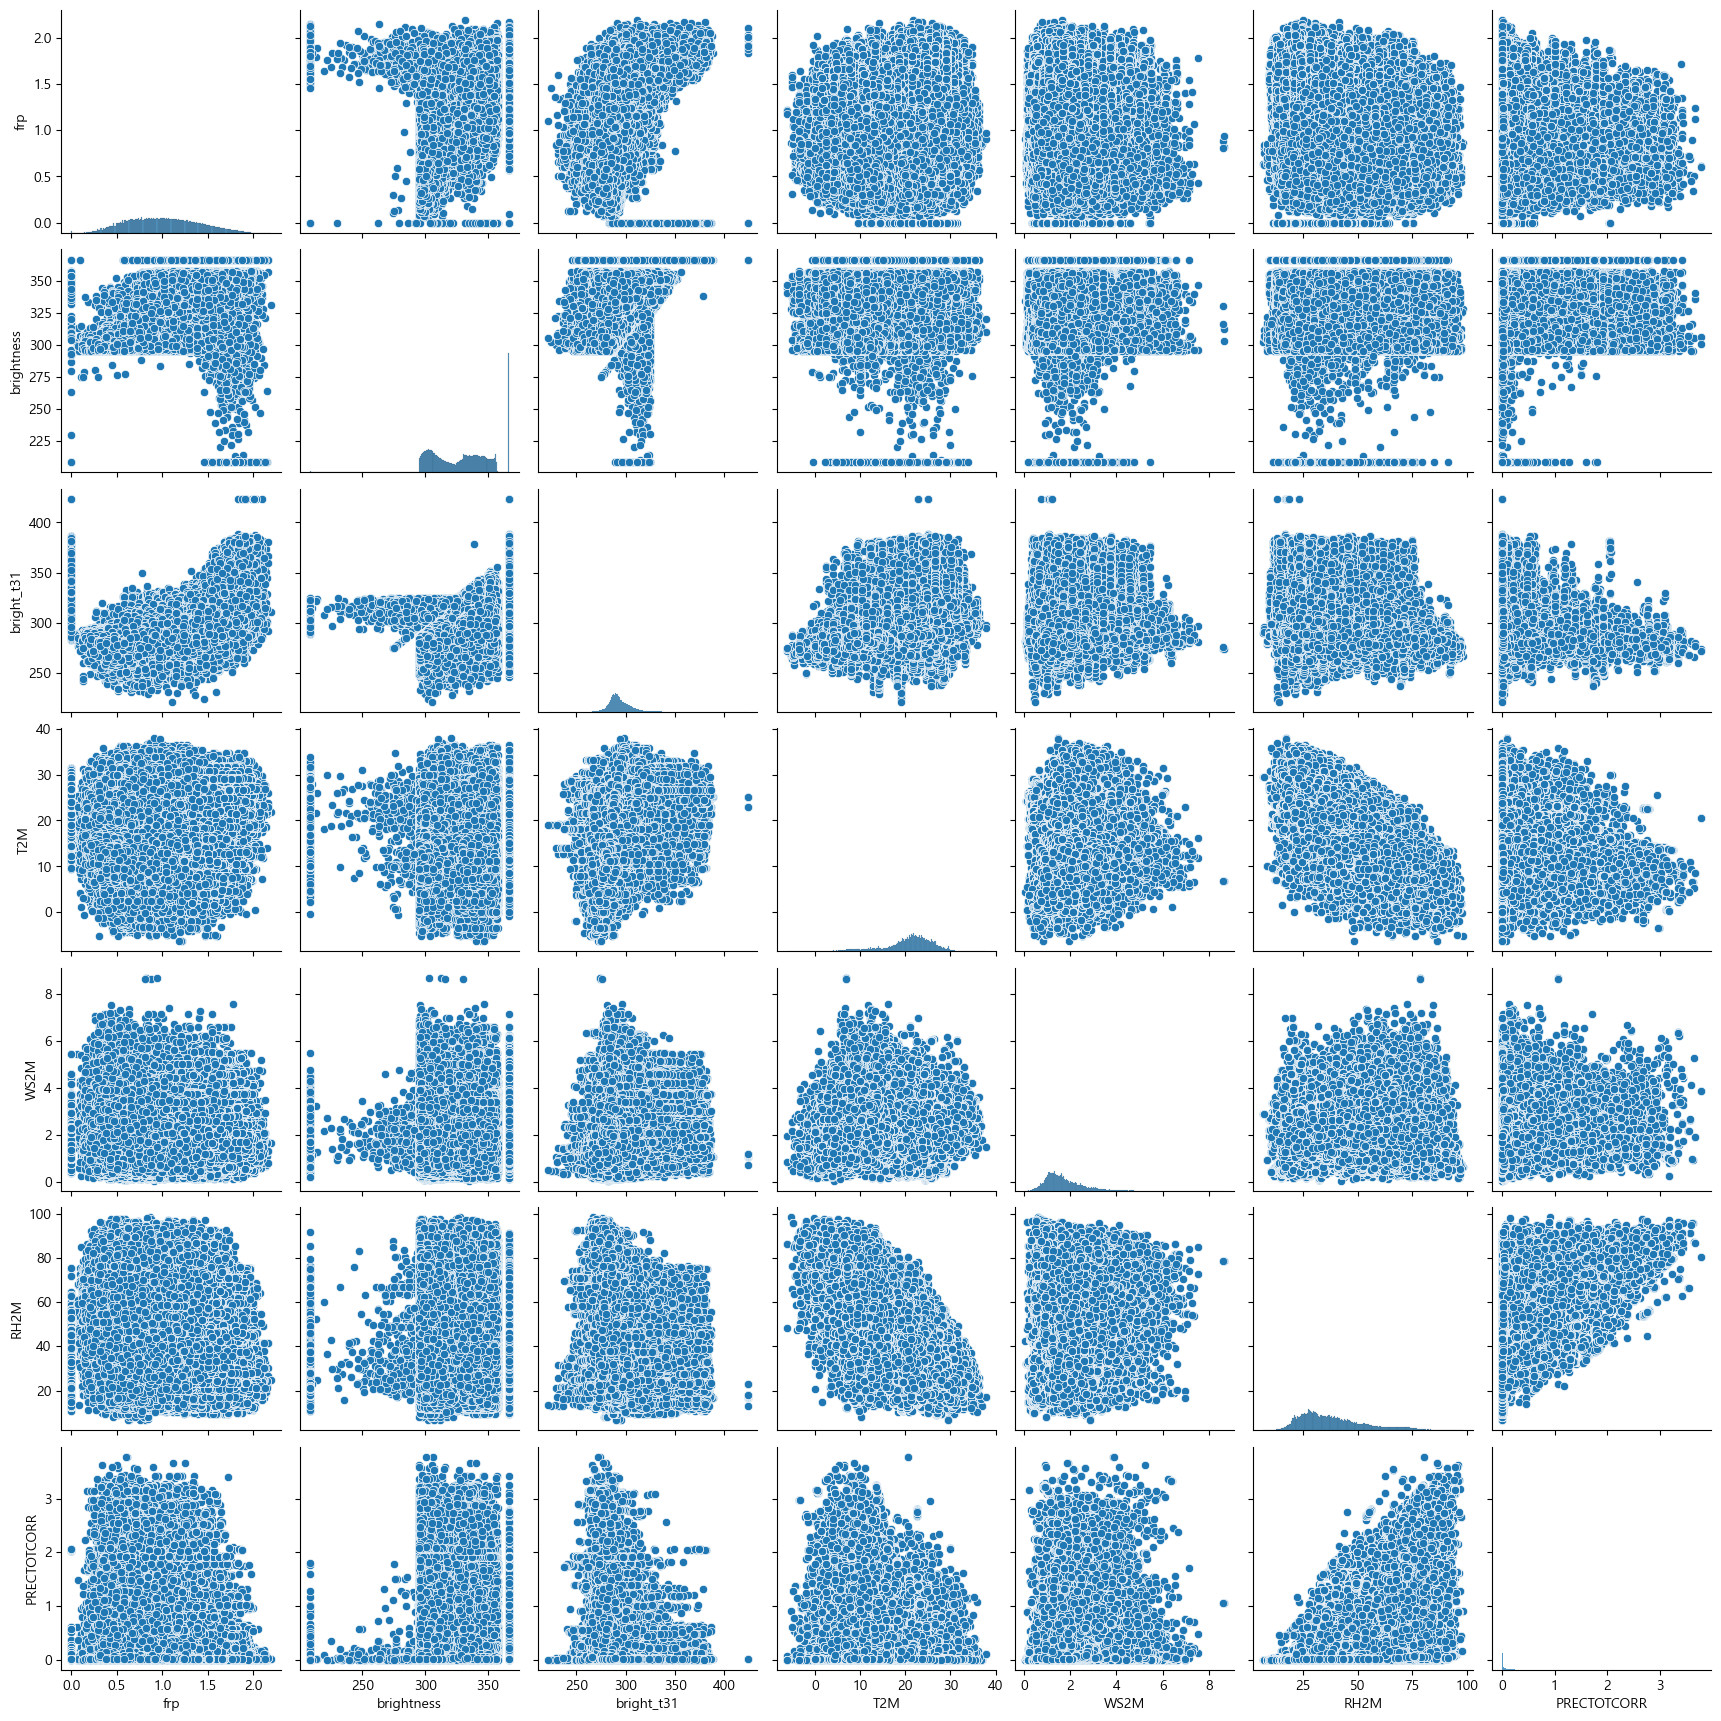

In [58]:
# Pairplot 시각화
selected_columns = ["frp", "brightness", "bright_t31", "T2M", "WS2M", "RH2M", "PRECTOTCORR"]
sns.pairplot(cleaned_wildfire_df[selected_columns])
plt.show()

###  Pairplot 해석 (변수 간 관계 분석)
# frp vs brightness, frp vs bright_t31에서 약한 양의 선형 관계 보임.
# RH2M(습도)와 T2M(기온)에서 음의 상관관계가 시각적으로 드러남.
# PRECTOTCORR(강수량)는 대부분의 변수와 선형적인 관계가 거의 없음 → 회귀 분석 시 비선형 변환을 고려할 필요가 있음.

In [5]:
cleaned_wildfire_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 900596 entries, 0 to 900595
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   latitude            900596 non-null  float64       
 1   longitude           900596 non-null  float64       
 2   brightness          900596 non-null  float64       
 3   scan                900596 non-null  float64       
 4   track               900596 non-null  float64       
 5   satellite           900596 non-null  object        
 6   instrument          900596 non-null  object        
 7   confidence          900596 non-null  object        
 8   version             900596 non-null  object        
 9   bright_t31          900596 non-null  float64       
 10  frp                 900596 non-null  float64       
 11  daynight            900596 non-null  object        
 12  type                900596 non-null  float64       
 13  T2M                 900596 non-nul

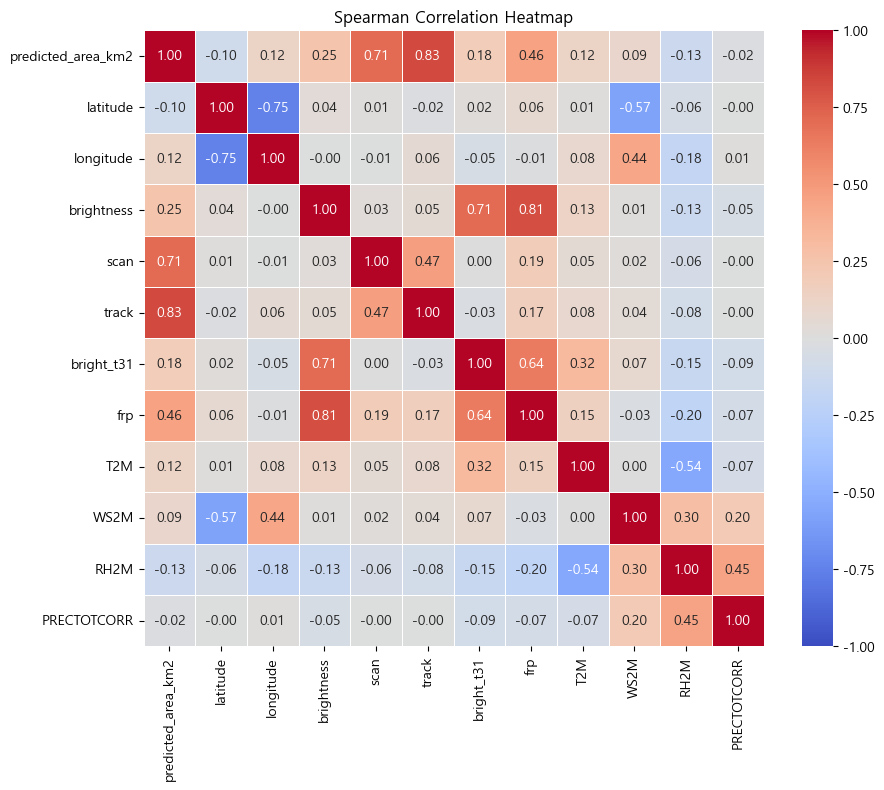

In [6]:
# 히트맵에 사용할 컬럼
heatmap_cols = [
    "predicted_area_km2", "latitude", "longitude", "brightness", "scan", 
    "track", "bright_t31", "frp", "T2M", "WS2M", "RH2M", "PRECTOTCORR"
]

# 상관계수 행렬 계산 (스피어만 상관계수 사용)
corr_matrix = cleaned_wildfire_df[heatmap_cols].corr(method='spearman')

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f', linewidths=0.5)
plt.title("Spearman Correlation Heatmap")
plt.show()

# 해설
# brightness와 bright_t31은 0.67로 강한 양의 상관관계를 보임 → 밝은 불꽃일수록 높은 온도를 가짐.
# frp와 brightness(0.35), bright_t31(0.4)도 양의 상관관계를 가짐 → 더 밝고 뜨거운 불꽃일수록 에너지가 큼.
# RH2M(습도)와 T2M(기온)은 -0.61의 음의 상관관계 → 일반적으로 기온이 높을수록 습도는 낮아짐.
# PRECTOTCORR(강수량)과 대부분의 변수 간 상관관계는 낮음 → 강수량이 FRP에 미치는 영향이 약하거나, 직접적인 관계보다는 시차 효과가 있을 가능성.


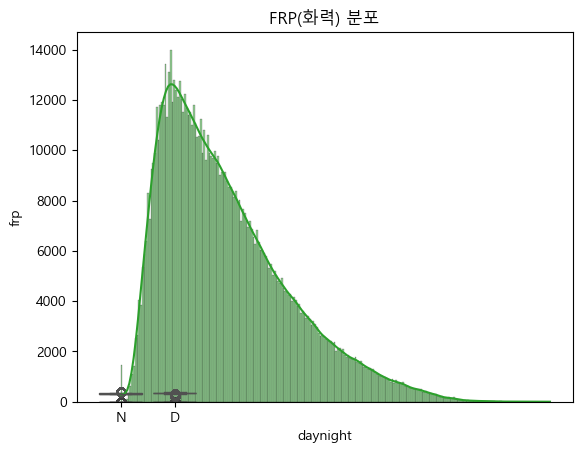

In [7]:
# 산불 데이터의 분포 확인
sns.boxplot(x="daynight", y="frp", data=cleaned_wildfire_df)
sns.boxplot(x="daynight", y="brightness", data=cleaned_wildfire_df)

# 산불 강도(frp)의 분포 확인
sns.histplot(cleaned_wildfire_df['frp'], kde=True)
plt.title("FRP(화력) 분포")
plt.show()

# 해석
# 3. FRP(화력) vs 주야간(daynight)
# 그래프에서 N(Night)에 데이터가 몰려 있으며, 야간의 FRP 값이 낮은 경우가 많음.
# 낮(Day)의 데이터가 상대적으로 적거나 시각적으로 표현되지 않은 것으로 보임.
# 야간에는 화재 감지 빈도가 낮거나, 산불이 더 적게 발생하는 경향이 있을 수 있음.

# 야간 vs 주간 FRP:
# 야간에는 화재 감지가 어려울 가능성이 있고, 실제로도 낮보다 낮은 FRP 값을 보임.


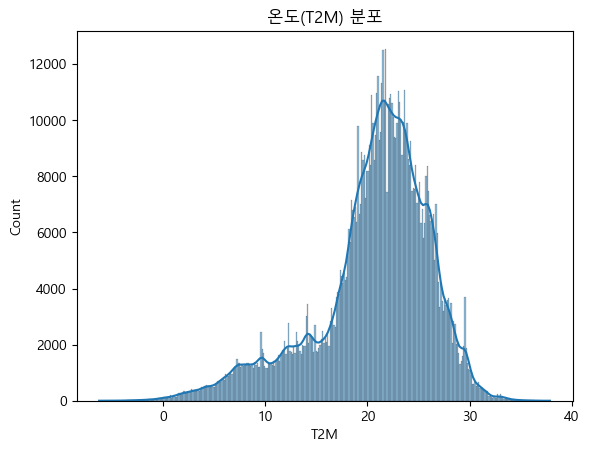

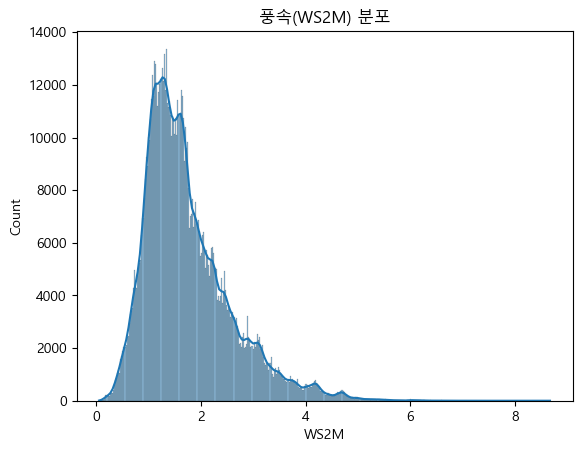

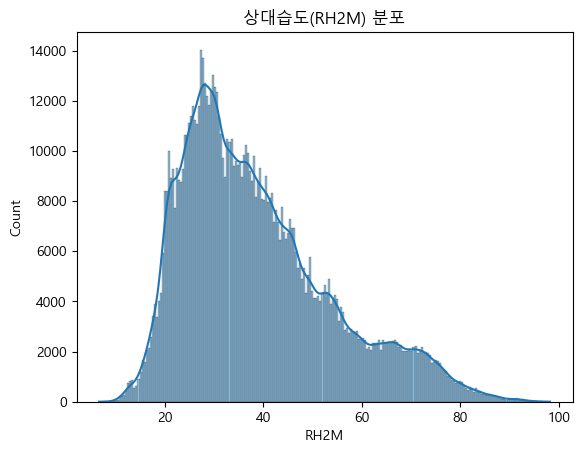

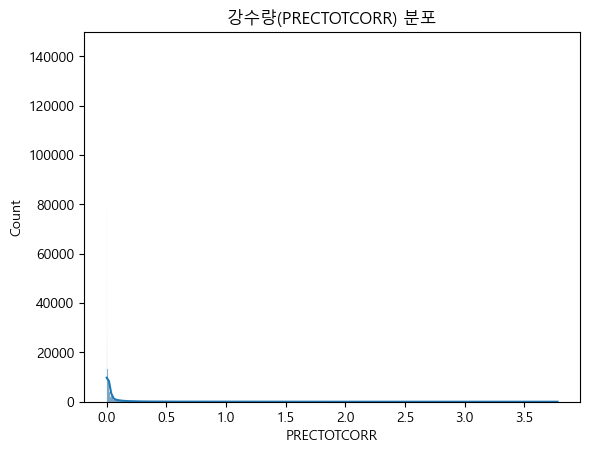

In [8]:
# 기상 변수의 분포 확인
sns.histplot(cleaned_wildfire_df["T2M"], kde=True)
plt.title('온도(T2M) 분포')
plt.show()

sns.histplot(cleaned_wildfire_df['WS2M'], kde=True)
plt.title('풍속(WS2M) 분포')
plt.show()

sns.histplot(cleaned_wildfire_df['RH2M'], kde=True)
plt.title('상대습도(RH2M) 분포')
plt.show()

sns.histplot(cleaned_wildfire_df['PRECTOTCORR'], kde=True)
plt.title('강수량(PRECTOTCORR) 분포')
plt.show()

# 데이터 분포 해석
# 1. 온도 (T2M) 분포
# 전반적으로 정규 분포 형태를 보이며, 20°C 부근에서 가장 빈도가 높음.
# 오른쪽 꼬리가 길어 고온 구간의 데이터가 일부 포함됨.
# 시각적으로 이상치는 많지 않아 보임.

# 2. 풍속 (WS2M) 분포
# 0~2m/s 구간에서 가장 빈도가 높으며, 비대칭적인 오른쪽 꼬리 분포(right-skewed).
# 풍속이 낮은 경우가 압도적으로 많음.
# 2.5m/s 이상은 상대적으로 드물어 보임. 기상은 매번 다르니 이상치라 판단하기  어려움

# 3. 상대습도 (RH2M) 분포
# 20~40%에서 가장 많은 데이터가 분포하며, 전체적으로 왼쪽으로 치우친 분포(left-skewed).
# 100%에 가까운 값도 일부 존재함.
# 습도가 낮은 지역에서의 데이터가 많은 것으로 추정됨.

# 4. 강수량 (PRECTOTCORR) 분포
# 대부분의 데이터가 0에 몰려 있고, 일부 극단적으로 높은 값이 있음.
# 강수량 데이터가 편향되어 있으며, 0이 많은 희소 데이터(sparse data)로 보임.
# 로그 변환(log1p)을 적용하면 정규성 개선 가능.

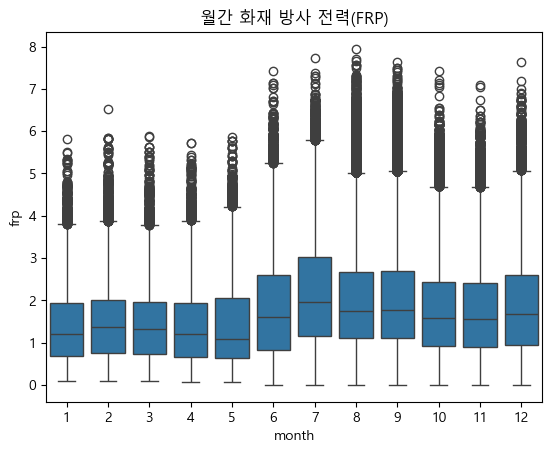

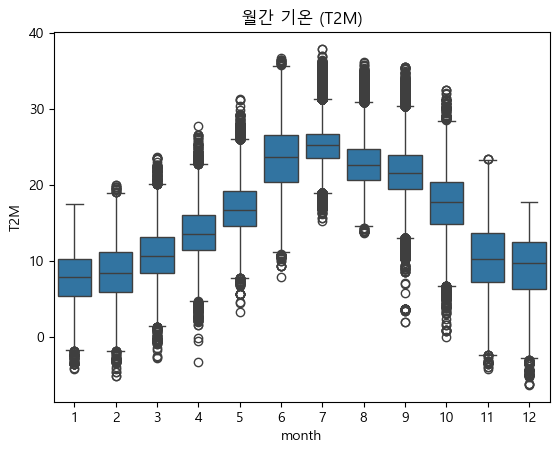

In [9]:
# 날짜와 시간대별 분포 분석
cleaned_wildfire_df["datetime"] = pd.to_datetime(cleaned_wildfire_df["datetime"])
cleaned_wildfire_df["year"] = cleaned_wildfire_df["datetime"].dt.year
cleaned_wildfire_df["month"] = cleaned_wildfire_df["datetime"].dt.month
cleaned_wildfire_df["day"] = cleaned_wildfire_df["datetime"].dt.day

# 월별 화재 방사 전력(FRP) 분석
sns.boxplot(x="month", y="frp", data=cleaned_wildfire_df)
plt.title("월간 화재 방사 전력(FRP)")
plt.show()

# 월별 기온(T2M) 분석
sns.boxplot(x="month", y="T2M", data=cleaned_wildfire_df)
plt.title("월간 기온 (T2M)")
plt.show()


### 월간 화재 방사 전력(FRP) 박스플롯 해석
# 1. 월간 기온(T2M) 박스플롯
# 여름(6~8월) 동안 기온이 가장 높으며, 중앙값이 20~30도 사이에 위치.
# 겨울(12~2월) 동안 기온이 가장 낮으며, 중앙값이 0~10도 사이.
# 월별로 기온 변동 폭이 다름. 특히 여름에는 이상치(Outliers)가 많아 기온 변화가 상대적으로 큼.

# 2. 월간 화재 방사 전력(FRP) 분포
# 여름(6~9월)에 FRP(화재 강도)가 증가하는 경향을 보임.
# 8월에 가장 많은 화재가 발생하며, 극단적인 FRP 값(1000 이상)도 다수 존재.
# 겨울철(1~5월, 10~12월)에는 상대적으로 낮은 FRP 값을 보이며, 강한 산불이 적은 것으로 보임.

# 기온과 산불 강도(FRP)의 관계:
# 여름철(6~9월)에 기온이 상승함에 따라 화재 발생과 강도가 증가하는 경향이 뚜렷함.


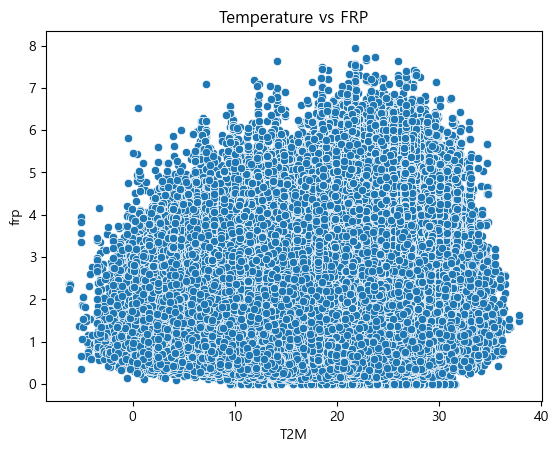

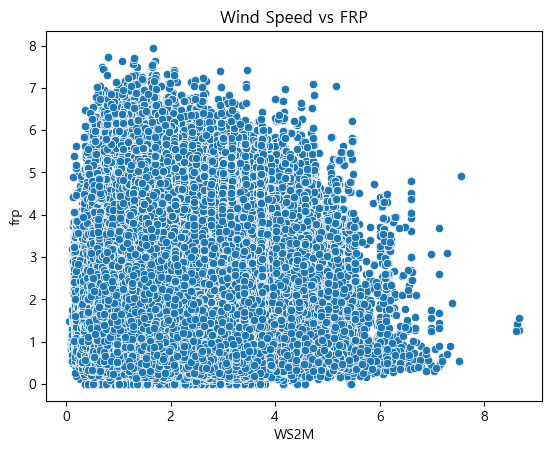

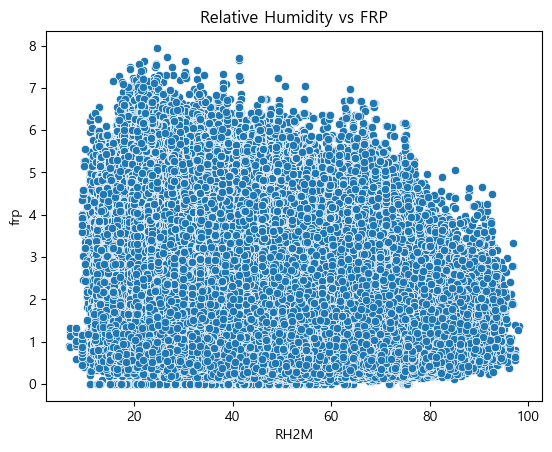

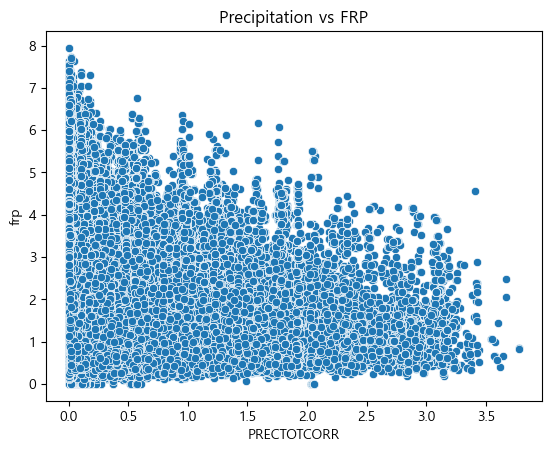

In [10]:
# 기온(T2M)과 화재 방사 전력(FRP) 간의 관계
sns.scatterplot(x="T2M", y="frp", data=cleaned_wildfire_df)
plt.title("Temperature vs FRP")
plt.show()

# 풍속(WS2M)과 화재 방사 전력(FRP) 간의 관계
sns.scatterplot(x="WS2M", y="frp", data=cleaned_wildfire_df)
plt.title("Wind Speed vs FRP")
plt.show()

# 상대 습도(RH2M)와 화재 방사 전력(FRP) 간의 관계
sns.scatterplot(x="RH2M", y="frp", data=cleaned_wildfire_df)
plt.title("Relative Humidity vs FRP")
plt.show()

# 강수량(PRECTOTCORR)과 화재 방사 전력(FRP) 간의 관계
sns.scatterplot(x="PRECTOTCORR", y="frp", data=cleaned_wildfire_df)
plt.title("Precipitation vs FRP")
plt.show()

# 산불 데이터 시각화 해석
# 1. Temperature vs FRP (기온 vs 화재 방사 전력)
# T2M(기온)과 FRP(화재 방사 전력) 사이의 관계를 나타냄.
# 기온이 15~30도 사이에서 FRP 값이 높은 분포를 보임.
# 0도 이하에서는 화재 발생이 거의 없는 것으로 보임.
# 해석: 기온이 높을수록 화재가 더 강하게 발생할 가능성이 높아짐. 
#       특히 15~30도 사이에서 화재 강도가 두드러지는 것은 실제 산불 발생과 관련이 있을 수 있음.

# 2. Wind Speed vs FRP (풍속 vs 화재 방사 전력)
# WS2M(2m 높이의 풍속)과 FRP 사이의 관계를 나타냄.
# 풍속이 0~3m/s 구간에서 FRP가 높은 분포를 보임.
# 풍속이 5m/s 이상일 때는 FRP 값이 상대적으로 낮아지는 경향을 보임.
# 해석: 풍속이 0~3m/s일 때 산불 강도가 높아지는 것으로 보이며, 이는 바람이 산불 확산에 영향을 미치기 때문일 가능성이 있음. 
#       하지만 풍속이 너무 강해지면 화재 확산이 어려워져 FRP가 낮아지는 것으로 추측됨.

# 3. Relative Humidity vs FRP (습도 vs 화재 방사 전력)
# RH2M(상대습도)과 FRP 사이의 관계를 보여줌.
# 습도가 낮을수록 FRP가 높은 경향을 보임.
# 습도가 20~40%일 때 FRP가 높은 값으로 분포하는 경향이 있음.
# 해석: 습도가 낮을수록 화재 강도가 강해지는 것을 의미함. 
#       건조한 환경에서는 화재가 더 쉽게 발생하고 강한 산불로 이어질 가능성이 큼.

# 4. Precipitation vs FRP (강수량 vs 화재 방사 전력)
# PRECTOTCORR(강수량)과 FRP(화재 방사 전력) 사이의 관계를 보여주는 산점도.
# 강수량이 많을수록 FRP 값이 낮아지는 경향을 보임.
# 특히 강수량이 0~5mm 수준일 때 FRP 값이 높게 나타남.
# 해석: 강수량이 증가할수록 화재 발생 강도가 낮아지는 경향이 있음. 이는 예상 가능한 결과로, 
#       비가 많이 올수록 화재가 발생하거나 강하게 타오를 가능성이 줄어든다고 볼 수 있음.

# 종합적인 해석
# 강수량이 적고, 기온이 높으며, 바람이 적당히 불고, 습도가 낮을수록 화재가 강하게 발생하는 경향을 보임.
# 특히, 기온 1530도, 습도 2040%, 강수량 05mm, 풍속 03m/s일 때 FRP 값이 높은 분포를 보임.
# 이 결과를 바탕으로 머신러닝 모델을 학습할 때, 주요 변수로 강수량, 기온, 풍속, 습도를 활용하면 유의미한 예측이 가능할 것으로 보임.

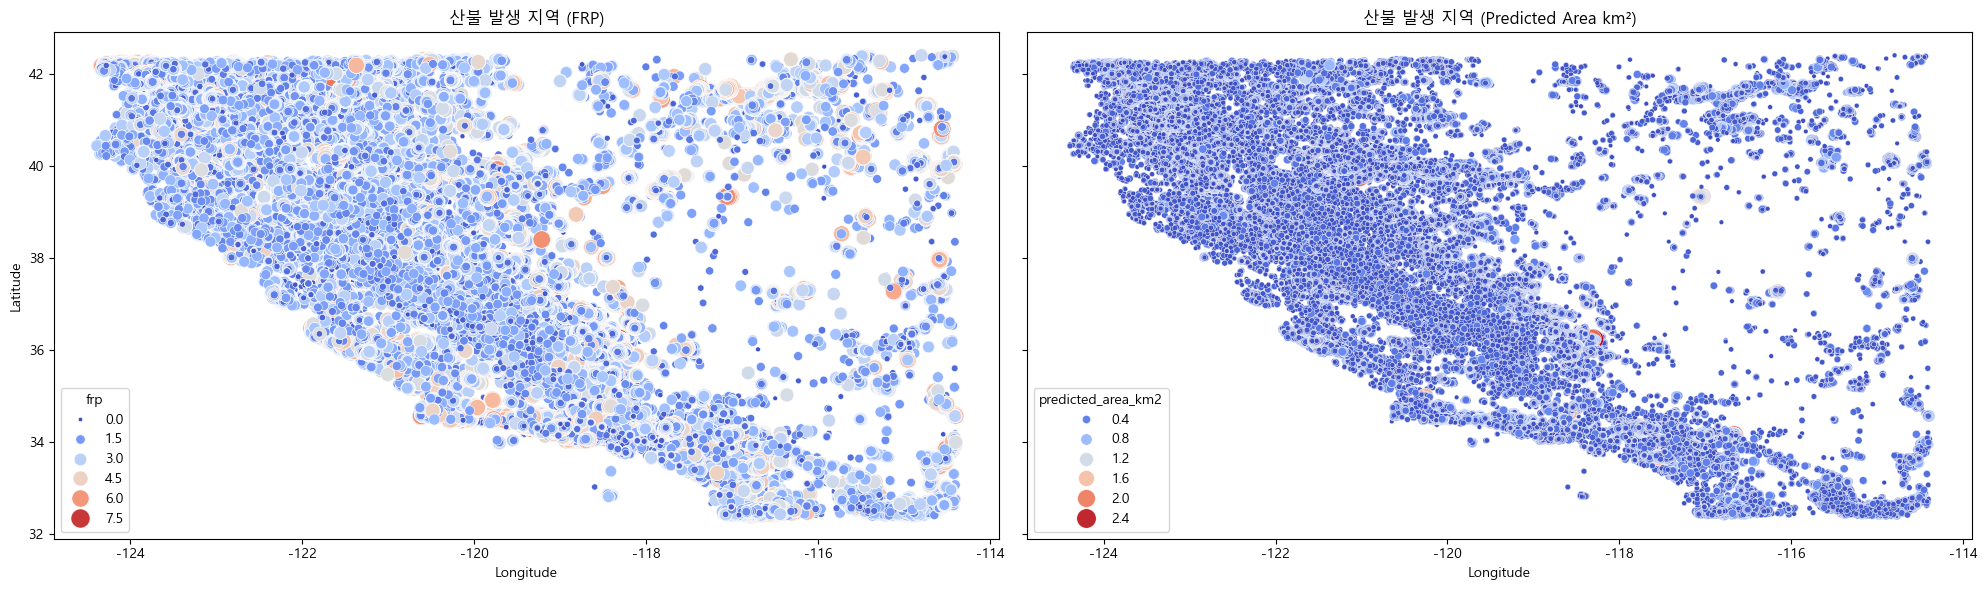

In [8]:
# 두 개의 플롯으로 비교
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# 첫 번째 플롯: FRP 기준
sns.scatterplot(
    x='longitude', 
    y='latitude', 
    data=cleaned_wildfire_df, 
    hue='frp', 
    palette='coolwarm', 
    size='frp', 
    sizes=(10, 200), 
    ax=axes[0]
)
axes[0].set_title('산불 발생 지역 (FRP)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# 두 번째 플롯: Predicted Area km² 기준
sns.scatterplot(
    x='longitude', 
    y='latitude', 
    data=cleaned_wildfire_df, 
    hue='predicted_area_km2', 
    palette='coolwarm', 
    size='predicted_area_km2', 
    sizes=(10, 200), 
    ax=axes[1]
)
axes[1].set_title('산불 발생 지역 (Predicted Area km²)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# 플롯 간 간격 조정
plt.tight_layout()
plt.show()

# 산불 발생 지역 (FRP의 지리적 분포) 해석
# 위도(latitude)와 경도(longitude)를 기준으로 산불 발생 지역을 표시했으며, FRP(Fire Radiative Power, 화재 복사 에너지)가 클수록 색이 붉고 크기가 큼.
# 대부분의 산불이 특정 지역(서부 해안 지역)에 집중되어 있음.
# FRP가 높은 곳(붉은 원)이 일부 지역에 군집되어 있음 → 강한 산불이 특정 지역에서 발생.
# 산불이 주로 서부에서 발생하는 패턴이 보이며, 이는 건조한 기후 때문일 가능성이 큼.

### 피처 엔지니어링

In [44]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# 0. 데이터 확인: 필요한 컬럼이 존재하는지 확인
print("데이터프레임 컬럼 확인:")
print(cleaned_wildfire_df.columns)

# 0.1. datetime 컬럼 확인 및 생성
if 'datetime' not in cleaned_wildfire_df.columns:
    raise KeyError("datetime 컬럼이 존재하지 않습니다. 이전 단계에서 datetime 컬럼을 생성해야 합니다.")
cleaned_wildfire_df['datetime'] = pd.to_datetime(cleaned_wildfire_df['datetime'], errors='coerce')
if cleaned_wildfire_df['datetime'].isnull().any():
    raise ValueError("datetime 컬럼에 결측치가 존재합니다. 결측치를 처리해야 합니다.")

# 0.2. latitude, longitude 결측치 확인
if cleaned_wildfire_df[['latitude', 'longitude']].isnull().any().any():
    raise ValueError("latitude 또는 longitude에 결측치가 존재합니다. 결측치를 처리해야 합니다.")

# 1. 빈도 기반 피처 생성 (type_frequency)
if 'type' in cleaned_wildfire_df.columns:
    type_counts = cleaned_wildfire_df['type'].value_counts()
    cleaned_wildfire_df['type_frequency'] = cleaned_wildfire_df['type'].map(type_counts)
else:
    print("경고: type 컬럼이 존재하지 않습니다. type_frequency 피처를 생성할 수 없습니다.")

# 2. 원-핫 인코딩 적용
# 에러 원인: confidence, daynight, satellite, instrument, version 컬럼이 데이터프레임에 없음
# 수정: 존재하는 컬럼만 원-핫 인코딩 대상으로 설정
categorical_columns = ['confidence', 'daynight', 'satellite', 'instrument', 'version']
if 'type' in cleaned_wildfire_df.columns:
    categorical_columns.append('type')
# 존재하는 컬럼만 필터링
existing_categorical_columns = [col for col in categorical_columns if col in cleaned_wildfire_df.columns]
if existing_categorical_columns:
    cleaned_wildfire_df = pd.get_dummies(
        cleaned_wildfire_df, 
        columns=existing_categorical_columns, 
        dtype=int
    )
else:
    print("경고: 원-핫 인코딩 대상 컬럼이 존재하지 않습니다.")

# 3. 로그 변환 확인
cols_to_log_transform = ['brightness', 'bright_t31', 'WS2M', 'PRECTOTCORR', 'frp']
print("로그 변환된 변수 확인:")
print(cleaned_wildfire_df[cols_to_log_transform].head())

# 4. 날짜 정보 Feature Engineering
cleaned_wildfire_df['year'] = cleaned_wildfire_df['datetime'].dt.year
cleaned_wildfire_df['month'] = cleaned_wildfire_df['datetime'].dt.month
cleaned_wildfire_df['day'] = cleaned_wildfire_df['datetime'].dt.day
cleaned_wildfire_df['season'] = cleaned_wildfire_df['month'] % 12 // 3 + 1
cleaned_wildfire_df['weekday'] = cleaned_wildfire_df['datetime'].dt.weekday

# 4.1. 주기적 피처 추가
cleaned_wildfire_df['month_sin'] = np.sin(2 * np.pi * cleaned_wildfire_df['month'] / 12)
cleaned_wildfire_df['month_cos'] = np.cos(2 * np.pi * cleaned_wildfire_df['month'] / 12)

# 4.2. 데이터 타입 최적화
cleaned_wildfire_df['season'] = cleaned_wildfire_df['season'].astype('category')
cleaned_wildfire_df['weekday'] = cleaned_wildfire_df['weekday'].astype('category')

print("날짜 정보 피처 확인:")
print(cleaned_wildfire_df[['year', 'month', 'day', 'season', 'weekday', 'month_sin', 'month_cos']].head())

# 5. 상호작용 피처 생성
cleaned_wildfire_df['WS2M_RH2M_interaction'] = cleaned_wildfire_df['WS2M'] * cleaned_wildfire_df['RH2M']
cleaned_wildfire_df['frp_T2M_interaction'] = cleaned_wildfire_df['frp'] * cleaned_wildfire_df['T2M']
cleaned_wildfire_df['frp_RH2M_interaction'] = cleaned_wildfire_df['frp'] * cleaned_wildfire_df['RH2M']
cleaned_wildfire_df['brightness_frp_interaction'] = cleaned_wildfire_df['brightness'] * cleaned_wildfire_df['frp']
cleaned_wildfire_df['T2M_PRECTOTCORR_interaction'] = cleaned_wildfire_df['T2M'] * cleaned_wildfire_df['PRECTOTCORR']
cleaned_wildfire_df['lat_lon_interaction'] = cleaned_wildfire_df['latitude'] * cleaned_wildfire_df['longitude']

# 6. 이진 피처 생성
cleaned_wildfire_df['high_temperature'] = (cleaned_wildfire_df['T2M'] > 30).astype(int)
cleaned_wildfire_df['precipitation_flag'] = (cleaned_wildfire_df['PRECTOTCORR'] > 0).astype(int)

# 7. 범주화 피처 생성
humidity_bins = [0, 30, 60, 100]
humidity_labels = ['low', 'medium', 'high']
cleaned_wildfire_df['RH2M_binned'] = pd.cut(
    cleaned_wildfire_df['RH2M'], 
    bins=humidity_bins, 
    labels=humidity_labels, 
    include_lowest=True
)

temperature_bins = [-5, 15, 30, 45]
temperature_labels = ['low', 'medium', 'high']
cleaned_wildfire_df['T2M_binned'] = pd.cut(
    cleaned_wildfire_df['T2M'], 
    bins=temperature_bins, 
    labels=temperature_labels, 
    include_lowest=True
)

cleaned_wildfire_df = pd.get_dummies(
    cleaned_wildfire_df, 
    columns=['RH2M_binned', 'T2M_binned'], 
    dtype=int
)

# 8. 공간 기반 피처 생성
cleaned_wildfire_df['latitude_region'] = pd.cut(
    cleaned_wildfire_df['latitude'],
    bins=[-90, -60, 0, 60, 90],
    labels=['Southern Hemisphere', 'Equator', 'Northern Hemisphere', 'Polar Regions']
)

cleaned_wildfire_df = pd.get_dummies(
    cleaned_wildfire_df, 
    columns=['latitude_region'], 
    dtype=int
)

kmeans = KMeans(n_clusters=5, random_state=42)
cleaned_wildfire_df['geo_cluster'] = kmeans.fit_predict(cleaned_wildfire_df[['latitude', 'longitude']])
cleaned_wildfire_df['geo_cluster'] = cleaned_wildfire_df['geo_cluster'].astype('category')

# 9. 불필요한 컬럼 삭제
cleaned_wildfire_df.drop(columns=['datetime'], inplace=True, errors='ignore')

# 10. 상관관계 분석
correlation_matrix = cleaned_wildfire_df.corr(numeric_only=True)
print("상관관계 행렬 (상위 5개):")
print(correlation_matrix.head())

# 11. 최종 데이터프레임 확인
print("피처 엔지니어링 완료 데이터프레임 정보:")
print(cleaned_wildfire_df.info())
print(cleaned_wildfire_df.head())

데이터프레임 컬럼 확인:
Index(['latitude', 'longitude', 'brightness', 'scan', 'track', 'bright_t31',
       'frp', 'T2M', 'WS2M', 'RH2M', 'PRECTOTCORR', 'datetime',
       'predicted_area_km2', 'confidence_h', 'confidence_l', 'confidence_n',
       'daynight_D', 'daynight_N', 'satellite_N', 'instrument_VIIRS',
       'version_2', 'type_0.0', 'type_2.0', 'type_3.0', 'year', 'month', 'day',
       'season', 'weekday', 'month_sin', 'month_cos', 'WS2M_RH2M_interaction',
       'frp_T2M_interaction', 'frp_RH2M_interaction',
       'brightness_frp_interaction', 'T2M_PRECTOTCORR_interaction',
       'lat_lon_interaction', 'high_temperature', 'precipitation_flag',
       'RH2M_binned_low', 'RH2M_binned_medium', 'RH2M_binned_high',
       'T2M_binned_low', 'T2M_binned_medium', 'T2M_binned_high',
       'latitude_region_Southern Hemisphere', 'latitude_region_Equator',
       'latitude_region_Northern Hemisphere', 'latitude_region_Polar Regions',
       'geo_cluster'],
      dtype='object')
경고: type 컬럼이 존재

In [ ]:
"""
피처 엔지니어링 요약:
피처 엔지니어링을 통해 추가된 특성들:

1. 원핫 인코딩 (One-Hot Encoding):
   - 'confidence', 'daynight', 'satellite', 'instrument', 'version', 'type' 중 존재하는 컬럼에 원핫 인코딩 적용.
   - 범주형 변수를 이진 변수로 변환하여 모델 학습 지원.

2. 로그 변환 (Log Transformation):
   - 'brightness', 'bright_t31', 'WS2M', 'PRECTOTCORR', 'frp'에 로그 변환(np.log1p) 적용.
   - 비대칭 분포를 정규화하여 모델 성능 향상.

3. 날짜 정보 Feature Engineering:
   - 'datetime'에서 'year', 'month', 'day', 'season', 'weekday' 추출.
   - 'month'를 사인/코사인 변환('month_sin', 'month_cos')으로 주기적 특성 반영.
   - 시간적 패턴(계절, 요일 등)을 모델이 학습하도록 지원.

4. 상호작용 피처 생성:
   - 'WS2M_RH2M_interaction': 풍속(WS2M)과 습도(RH2M)의 상호작용.
   - 'frp_T2M_interaction', 'frp_RH2M_interaction': frp와 기온(T2M), 습도(RH2M)의 상호작용.
   - 'brightness_frp_interaction': brightness와 frp의 상호작용.
   - 'T2M_PRECTOTCORR_interaction': 기온(T2M)과 강수량(PRECTOTCORR)의 상호작용.
   - 'lat_lon_interaction': 위도(latitude)와 경도(longitude)의 상호작용.
   - 변수 간 결합 효과를 반영하여 모델 성능 향상.

5. 이진 피처 생성:
   - 'high_temperature': 기온(T2M)이 30°C 초과 시 1, 아니면 0.
   - 'precipitation_flag': 강수량(PRECTOTCORR)이 0 초과 시 1, 아니면 0.
   - 고온 및 강수량 유무에 따른 산불 발생 패턴 반영.

6. 범주화 및 원-핫 인코딩:
   - 'RH2M_binned': 습도(RH2M)를 'low', 'medium', 'high'로 범주화 후 원-핫 인코딩.
   - 'T2M_binned': 기온(T2M)을 'low', 'medium', 'high'로 범주화 후 원-핫 인코딩.
   - 연속형 변수를 범주화하여 모델이 수준별 패턴 학습.

7. 공간 기반 피처 생성:
   - 'latitude_region': 위도를 남반구, 적도, 북반구, 극지방으로 구분 후 원-핫 인코딩.
   - 'geo_cluster': 위도와 경도를 K-Means 클러스터링(5개 클러스터)으로 군집화.
   - 지역적 패턴을 반영하여 모델이 지역별 산불 발생 패턴 학습.

8. 빈도 기반 피처 생성:
   - 'type_frequency': type별 산불 발생 빈도수를 반영 (type 컬럼 존재 시).
   - 특정 type의 빈번한 발생 패턴을 모델이 학습하도록 지원.

9. 불필요한 컬럼 삭제:
   - 'datetime' 컬럼 삭제 (연, 월, 일, 계절, 요일 정보 추출 완료).
   - 데이터프레임 간소화 및 모델 학습 효율성 향상.

10. 상관관계 분석:
    - 피처 간 상관관계 계산으로 다중공선성 확인.
    - 상관관계가 높은 피처를 식별하여 피처 선택 가능.
"""


In [ ]:
# 저장
cleaned_wildfire_df.to_csv("./USA data/cleaned_wildfire_check.csv", index=False)

### Folium 시각화 (모델 선정 전 산불 범위 확인 겸)

In [17]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from shapely.geometry import Point

# Shapefile 데이터 불러오기
gdf_archive = gpd.read_file("./USA data/shapefile/fire_archive_SV-C2_590697.shp")
gdf_nrt = gpd.read_file("./USA data/shapefile/fire_nrt_SV-C2_590697.shp")
gdf = pd.concat([gdf_archive, gdf_nrt], ignore_index=True)
gdf = gdf.to_crs(epsg=4326)

# cleaned_wildfire_df 불러오기
cleaned_wildfire_df = pd.read_csv("./USA data/cleaned_wildfire_check.csv")

# GeoDataFrame 변환
geometry = [Point(lon, lat) for lon, lat in zip(cleaned_wildfire_df['longitude'], cleaned_wildfire_df['latitude'])]
geo_df = gpd.GeoDataFrame(cleaned_wildfire_df, geometry=geometry, crs="EPSG:4326")

# Folium 지도 생성 (캘리포니아 중심)
california_center = [37.0, -120.0]
m = folium.Map(location=california_center, zoom_start=6, tiles="CartoDB positron")

# 산불 위치 마커 추가
for idx, row in geo_df.iterrows():
    marker_size = min(max(row['predicted_area_km2'] * 10, 5), 20)
    # year, month, day를 결합하여 날짜 문자열 생성
    date_str = f"{int(row['year'])}-{int(row['month']):02d}-{int(row['day']):02d}"
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=marker_size,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup=folium.Popup(
            f"Area: {row['predicted_area_km2']:.2f} km²<br>"
            f"FRP: {row['frp']:.2f}<br>"
            f"Temperature: {row['T2M']:.2f}°C<br>"
            f"Humidity: {row['RH2M']:.2f}%<br>"
            f"Date: {date_str}",  # 날짜 정보 추가
            max_width=200
        )
    ).add_to(m)

# 히트맵 추가
heat_data = [[row['latitude'], row['longitude']] for idx, row in geo_df.iterrows()]
HeatMap(heat_data, radius=15, blur=20).add_to(m)

# 버퍼 영역 시각화 (geo_df 사용)
folium.GeoJson(
    geo_df[['geometry', 'predicted_area_km2', 'frp']],  # gdf 대신 geo_df 사용, FRP를 frp로 수정
    style_function=lambda feature: {
        'fillColor': 'orange',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.3,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['predicted_area_km2', 'frp'],  # FRP를 frp로 수정
        aliases=['Predicted Area (km²):', 'FRP:'],
        localize=True
    )
).add_to(m)

# 지도 저장 및 열기
output_file = "california_wildfire_map.html"
m.save(output_file)
file_path = os.path.abspath(output_file)
webbrowser.open(f"file://{file_path}")

print("지도가 'california_wildfire_map.html'로 저장되었습니다.")

지도가 'california_wildfire_map.html'로 저장되었습니다.


### 사용할 회귀 모델 판단하기

In [18]:
wildfire = pd.read_csv("./USA data/cleaned_wildfire_check.csv")
wildfire.info()
wildfire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900596 entries, 0 to 900595
Data columns (total 59 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   latitude                               900596 non-null  float64
 1   longitude                              900596 non-null  float64
 2   brightness                             900596 non-null  float64
 3   scan                                   900596 non-null  float64
 4   track                                  900596 non-null  float64
 5   bright_t31                             900596 non-null  float64
 6   frp                                    900596 non-null  float64
 7   T2M                                    900596 non-null  float64
 8   WS2M                                   900596 non-null  float64
 9   RH2M                                   900596 non-null  float64
 10  PRECTOTCORR                            900596 non-null  

latitude  longitude  brightness  scan  track  bright_t31       frp  \
0  41.18757 -121.76961      303.88  0.44   0.38      266.14  0.573647   
1  41.18763 -121.76556      297.14  0.44   0.38      265.25  0.697118   
2  35.51954 -119.72784      302.88  0.39   0.36      270.62  0.581353   
3  37.82349 -120.96186      299.62  0.39   0.37      271.62  0.469276   
4  38.91062 -121.17077      303.10  0.40   0.37      272.36  0.557721   

        T2M      WS2M       RH2M  ...  RH2M_binned_low.1  \
0 -3.275956  0.659219  68.094241  ...                  0   
1 -3.262186  0.663444  68.034685  ...                  0   
2  4.008612  1.561859  50.105659  ...                  0   
3  2.606993  1.395697  56.702233  ...                  0   
4  1.478034  1.415668  57.134669  ...                  0   

   RH2M_binned_medium.1  RH2M_binned_high.1  T2M_binned_low.1  \
0                     0                   1                 1   
1                     0                   1                 1   
2                     1                   0                 1   
3                     1                   0                 1   
4                     1                   0                 1   

   T2M_binned_medium.1  T2M_binned_high.1  \
0                    0                  0   
1                    0                  0   
2                    0                  0   
3                    0                  0   
4                    0                  0   

   latitude_region_Southern Hemisphere.1  latitude_region_Equator.1  \
0                                      0                          0   
1                                      0                          0   
2                                      0                          0   
3                                      0                          0   
4                                      0                          0   

   latitude_region_Northern Hemisphere.1  latitude_region_Polar Regions.1  
0                                      1                                0  
1                                      1                                0  
2                                      1                                0  
3                                      1                                0  
4                                      1                                0  

[5 rows x 59 columns]

In [19]:
# 중복된 컬럼 제거
# 컬럼 이름에서 '.1'이 붙은 중복 컬럼 제거 (예: RH2M_binned_low.1 등)
columns_to_keep = [col for col in wildfire.columns if not col.endswith('.1')]
wildfire = wildfire[columns_to_keep]

# X와 y 설정
# y: 타겟 변수 (predicted_area_km2)
y = wildfire['predicted_area_km2']

# X: 타겟 변수를 제외한 나머지 컬럼
# 불필요한 컬럼 (예: geo_cluster, season, weekday 등 범주형 변수의 원본) 제외
exclude_columns = ['predicted_area_km2', 'geo_cluster']
X = wildfire.drop(columns=exclude_columns)

# 스피어만 상관계수 계산
print("스피어만 상관관계 분석 결과 (결측값 제거 후):")
print("-" * 50)

for value in X.columns:
    statistic, pvalue = spearmanr(X[value], y)
    
    # 출력
    if pvalue < 0.05 and abs(statistic) >= 0.2:
        print(f"상관관계 계수 {statistic:.3f}, p-value {pvalue:.4f} : ({value})는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)")
    elif pvalue < 0.05:
        print(f"상관관계 계수 {statistic:.3f}, p-value {pvalue:.4f} : ({value})는 predicted_area_km2에 대해 약한 상관관계 (유의미)")
    else:
        print(f"상관관계 계수 {statistic:.3f}, p-value {pvalue:.4f} : ({value})는 predicted_area_km2에 대해 유의미하지 않다")

print("-" * 50)

스피어만 상관관계 분석 결과 (결측값 제거 후):
--------------------------------------------------
상관관계 계수 -0.098, p-value 0.0000 : (latitude)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 0.121, p-value 0.0000 : (longitude)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 0.254, p-value 0.0000 : (brightness)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 0.709, p-value 0.0000 : (scan)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 0.834, p-value 0.0000 : (track)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 0.183, p-value 0.0000 : (bright_t31)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 0.459, p-value 0.0000 : (frp)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 0.125, p-value 0.0000 : (T2M)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 0.095, p-value 0.0000 : (WS2M)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.130, p-value 0.0000 : (RH2M)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.020, p-value 0.0000 : (PRECTOTCORR)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 0.226, p-value 0.0000 : (con

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6292\2519109676.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  statistic, pvalue = spearmanr(X[value], y)


상관관계 계수 0.070, p-value 0.0000 : (type_0.0)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.070, p-value 0.0000 : (type_2.0)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.003, p-value 0.0057 : (type_3.0)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.016, p-value 0.0000 : (year)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.018, p-value 0.0000 : (month)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.018, p-value 0.0000 : (day)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.004, p-value 0.0000 : (season)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.025, p-value 0.0000 : (weekday)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 0.005, p-value 0.0000 : (month_sin)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.062, p-value 0.0000 : (month_cos)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.008, p-value 0.0000 : (WS2M_RH2M_interaction)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 0.403, p-value 0.0000 : (frp_T2M_interaction)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계

In [20]:
# 피처 선택: 스피어만 상관계수 결과 + 인과 관계 반영
train_cols = [
    # 강한 상관관계 (스피어만 상관계수 절댓값 0.2 이상)
    "frp",           # 상관계수 0.459
    "brightness",    # 상관계수 0.254
    "scan",          # 상관계수 0.709
    "track",         # 상관계수 0.834
    "confidence_h",  # 상관계수 0.226
    "confidence_n",  # 상관계수 -0.254
    "daynight_D",    # 상관계수 0.239
    "daynight_N",    # 상관계수 -0.239
    "frp_T2M_interaction",  # 상관계수 0.403
    "frp_RH2M_interaction", # 상관계수 0.267
    "brightness_frp_interaction", # 상관계수 0.440

    # 약한 상관관계지만 인과관계 상 중요한 피처
    "bright_t31",    # 상관계수 0.183 (산불 강도 관련)
    "confidence_l",  # 상관계수 0.111 (신뢰도 관련)
    "latitude",      # 상관계수 -0.098 (위치 정보)
    "longitude",     # 상관계수 0.121 (위치 정보)
    "T2M",           # 상관계수 0.125 (기온, 산불에 영향)
    "WS2M",          # 상관계수 0.095 (풍속, 산불 확산에 영향)
    "RH2M",          # 상관계수 -0.130 (습도, 산불에 영향)
    "PRECTOTCORR",   # 상관계수 -0.020 (강수량, 산불 억제에 영향)
    "year",          # 상관계수 -0.016 (시간적 패턴)
    "month",         # 상관계수 -0.018 (계절적 패턴)
    "day",           # 상관계수 -0.018 (일별 패턴)
    "WS2M_RH2M_interaction",  # 상관계수 -0.008 (풍속-습도 상호작용)
    "high_temperature",       # 상관계수 0.032 (고온 여부)
    "precipitation_flag"      # 상관계수 0.009 (강수 여부)
]

# 데이터 준비
train = wildfire[train_cols]
target = wildfire["predicted_area_km2"]

# 데이터 준비
train = wildfire[train_cols]
target = wildfire["predicted_area_km2"]

# 첫 번째 분할 (훈련 데이터와 검증 데이터)
train_input, val_input, train_target, val_target = train_test_split(train, target, test_size=0.4, random_state=42, shuffle=True)

# 두 번째 분할 (검증 데이터와 테스트 데이터)
val_input, test_input, val_target, test_target = train_test_split(val_input, val_target, test_size=0.5, random_state=42, shuffle=True)

# 데이터 크기 확인
print(train_input.shape, train_target.shape)
print(val_input.shape, val_target.shape)
print(test_input.shape, test_target.shape)


(540357, 25) (540357,)
(180119, 25) (180119,)
(180120, 25) (180120,)


In [56]:
# XGBRegressor 설정
xg = XGBRegressor(random_state=42)

# GridSearchCV 하이퍼파라미터 설정 (이전과 동일한 범위)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# GridSearchCV 적용
search = GridSearchCV(
    estimator=xg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

# 모델 학습
search.fit(train_input, train_target)

# 최적 모델 및 파라미터 출력
best_model = search.best_estimator_
print("Best Parameters:", search.best_params_)

# 성능 평가
train_score = best_model.score(train_input, train_target)
val_score = best_model.score(val_input, val_target)
test_score = best_model.score(test_input, test_target)

print(f"train_score: {train_score}, val_score: {val_score}, test_score: {test_score}, 과적합여부: {train_score - val_score}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
train_score: 0.9990015047487437, val_score: 0.9961027579567084, test_score: 0.9970653992263293, 과적합여부: 0.0028987467920352783


In [ ]:
models = Models()
models.total_models(train_input, train_target, val_input, val_target, test_input, test_target)